In [1]:
!pip install --upgrade pip
!pip install python-decouple
!pip install geoalchemy2
!pip install shapely
!pip install scipy
!pip install tpot
!pip3 install xgboost

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (19.1.1)
^C
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/pip", line 11, in <module>
    sys.exit(main())
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pip/_internal/__init__.py", line 78, in main
    return command.main(cmd_args)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pip/_internal/cli/base_command.py", line 230, in main
    pip_version_check(session, options)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pip/_internal/utils/outdated.py", line 102, in pip_version_check
    installed_version = get_installed_version("pip")
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pip/_internal/utils/misc.py", line 889, in get_installed_version
    working_set = pkg_resources.WorkingSet()
  File "/ho

In [2]:
from sqlalchemy import create_engine, func, text
from sqlalchemy.orm import sessionmaker
from decouple import config
from shapely import wkb, wkt
from shapely.geometry import Point
from geoalchemy2.shape import to_shape 

import pandas as pd
import numpy as np
import random
import json
from datetime import datetime, timedelta
import re
from matplotlib import pyplot as plt

from sklearn.preprocessing import RobustScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

from IPython.core.debugger import set_trace

Using TensorFlow backend.


In [3]:
"""Contains models for DB."""

from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, BigInteger, Integer, String, DateTime, ForeignKey, Float
from sqlalchemy.orm import relationship
from geoalchemy2 import Geometry


BASE = declarative_base()


class City(BASE):
    """City model for DB. Has information of cities."""
    __tablename__ = 'city'
    id            = Column(BigInteger, primary_key=True)
    city          = Column(String, unique=False, nullable=False)
    state         = Column(String, unique=False, nullable=True)
    country       = Column(String, unique=False, nullable=False)
    location      = Column(Geometry(geometry_type='POINT'), nullable=False)
    blocks        = relationship("Blocks", back_populates="city")
    zipcodes      = relationship("ZipcodeGeom", back_populates="city")
    incidents     = relationship("Incident", back_populates="city")


class Blocks(BASE):
    """Block model for DB. Has information of city blocks for a related city
        id."""
    __tablename__ = 'block'
    id            = Column(BigInteger, primary_key=True)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    shape         = Column(Geometry(geometry_type='MULTIPOLYGON'), nullable=False)
    population    = Column(Integer, nullable=False)
    city          = relationship("City", back_populates="blocks")
    incidents     = relationship("Incident", back_populates="block")

class ZipcodeGeom(BASE):
    """Zipcode geometry model for DB. Has information of zipcodes and related
        city id."""
    __tablename__ = 'zipcodegeom'
    id            = Column(BigInteger, primary_key=True)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    zipcode       = Column(String, nullable=False, unique=True)
    shape         = Column(Geometry(geometry_type='MULTIPOLYGON'), nullable=False)
    city          = relationship("City", back_populates="zipcodes")

class Incident(BASE):
    """Incident model for DB. Has information of a specific crime, including
        where it took place, when it took place, and the type of crime that
        occurred."""
    __tablename__ = 'incident'
    id            = Column(BigInteger, primary_key=True)
    crimetypeid   = Column(BigInteger, ForeignKey('crimetype.id'), nullable=False)
    locdescid     = Column(BigInteger, ForeignKey('locdesctype.id'), nullable=False)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    blockid       = Column(BigInteger, ForeignKey('block.id'), nullable=False)
    location      = Column(Geometry(geometry_type='POINT'), nullable=False)
    datetime      = Column(DateTime, nullable=False)
    hour          = Column(Integer, nullable=False)
    dow           = Column(Integer, nullable=False)
    month         = Column(Integer, nullable=False)
    year          = Column(Integer, nullable=False)
    city          = relationship("City", back_populates="incidents")
    block         = relationship("Blocks", back_populates="incidents")
    crimetype     = relationship("CrimeType", back_populates="incidents")
    locationdesc  = relationship("LocationDescriptionType", back_populates="incidents")

class CrimeType(BASE):
    """CrimeType model for DB. Has information of the types of crime, including
        a general description and the numerical severity of the crime."""
    __tablename__ = 'crimetype'
    id            = Column(BigInteger, primary_key=True)
    category      = Column(String, unique=True, nullable=False)
    severity      = Column(Integer, nullable=False)
    incidents     = relationship("Incident", back_populates="crimetype")


class LocationDescriptionType(BASE):
    """Location description model for DB. Has information on the type of
        location that the crime took place."""
    __tablename__ = 'locdesctype'
    id            = Column(BigInteger, primary_key=True)
    key1          = Column(String, nullable=False)
    key2          = Column(String, nullable=False)
    key3          = Column(String, nullable=False)
    incidents     = relationship("Incident", back_populates="locationdesc")

In [4]:
class GetData(object):
    def go(self, SESSION, start_year, end_year):
        SQL_QUERY = \
            f'''
                SELECT
                    incident.blockid,
                    incident.year,
                    incident.month,
                    incident.dow,
                    incident.hour,
                    SUM(crimetype.severity)/AVG(block.population) AS severity
                FROM incident
                INNER JOIN block ON incident.blockid = block.id
                INNER JOIN crimetype ON incident.crimetypeid = crimetype.id
                    AND block.population > 0
                    AND incident.cityid = 1
                    AND incident.year >= {start_year}
                    AND incident.year <= {end_year}
                GROUP BY
                    incident.blockid,
                    incident.year,
                    incident.month,
                    incident.dow,
                    incident.hour
            '''
        return SESSION.execute(text(SQL_QUERY)).fetchall()

In [21]:
def process_data(data, start_year, end_year, map_risk):

    # records is the list of rows we get from the query with this order:
    #   blockid, year, month, dow, hour, risk
    #   month is from 1 - 12
    #   `POINT(<lat> <lng>)`
    
    NUM_BLOCKIDS = 801
    START_MONTH = START_MONTH_LAST_YEAR = 1
    
    if (end_year - start_year + 1) != 3:
        raise ValueError('3 years must be passed in')

    years_data_X = years_data_y = 2
    X = np.zeros((NUM_BLOCKIDS, years_data_X*12*7*24 + 1))
    y = np.zeros((NUM_BLOCKIDS, years_data_y*12*7*24 + 1))

    #     for r in data:
    #         if r[1] == start_year:
    #             X[r[0]-1, (((12*r[1]+r[2]-1)-(start_year*12+START_MONTH-1))*7+r[3])*24+r[4]] = float(r[5])
    #         elif r[1] == end_year:
    #             y[r[0]-1, (((12*r[1]+r[2]-1)-(end_year*12+START_MONTH_LAST_YEAR-1))*7+r[3])*24+r[4]] = float(r[5])
    #         else:  # common years to X and y
    #             if r[1] == start_year+1:
    #                 X[r[0]-1, (((12*r[1]+r[2]-1)-(start_year*12+START_MONTH-1))*7+r[3])*24+r[4]] = float(r[5])
    #             else:
    #                 y[r[0]-1, (((12*r[1]+r[2]-1)-(end_year*12+START_MONTH_LAST_YEAR-1))*7+r[3])*24+r[4]] = float(r[5])

    for r in data:
        if r[1] == start_year:
            if r[1] == end_year:
                y[r[0]-1, (((12*r[1]+r[2]-1)-(end_year*12+START_MONTH_LAST_YEAR-1))*7+r[3])*24+r[4]] = \
                    map_risk(float(r[5]))
            else:
                X[r[0]-1, (((12*r[1]+r[2]-1)-(start_year*12+START_MONTH-1))*7+r[3])*24+r[4]] = \
                    map_risk(float(r[5]))

    X[:, -1] = start_year*12+START_MONTH-1

    df_X = pd.DataFrame()
    df_X

    return [x1 for xs in X for x1 in xs], [y1 for ys in y for y1 in ys]


In [6]:
from contextlib import contextmanager

@contextmanager
def session_scope():
    """Provide a transactional scope around a series of operations."""

    DB_URI  = config('DB_URI')
    ENGINE  = create_engine(DB_URI)
    Session = sessionmaker(bind=ENGINE)
    SESSION = Session()
    
    try:
        yield SESSION
        SESSION.commit()
    except:
        SESSION.rollback()
        raise
    finally:
        SESSION.close()


def ready_data(training_start_year, training_end_year,
               testing_start_year, testing_end_year,
               map_risk):
    with session_scope() as session:
        training_data = GetData().go(session,
                                     training_start_year,
                                     training_end_year)
        testing_data = GetData().go(session,
                                     testing_start_year,
                                     testing_end_year)
        
        X_train, y_train = process_data(training_data,
                                        training_start_year, 
                                        training_end_year,
                                        map_risk)
        X_test, y_test = process_data(testing_data,
                                      testing_start_year, 
                                      testing_end_year,
                                      map_risk)

    return X_train, X_test, y_train, y_test

In [7]:
def map_risk_1(risk):
    return np.power(risk * 1e5, 2)

def map_risk_0(risk):
    return risk

def map_risk_2(risk):
    return np.power(risk * 1e5, 3)

def map_risk_3(risk):
    return np.power(risk * 1e5, 4)

map_risk = [map_risk_1, map_risk_2, map_risk_3]  # , map_risk_1, map_risk_2, map_risk_3]

In [8]:
%%time
X_train, X_test, y_train, y_test = ready_data(2015, 2017, 2016, 2018, map_risk_0)
print(len(X_train), len(y_train), len(X_test), len(y_test))

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


3230433 3230433 3230433 3230433
CPU times: user 4.3 s, sys: 652 ms, total: 4.95 s
Wall time: 24.7 s


In [9]:
X_train_saved, y_train_saved, X_test_saved, y_test_saved = X_train, y_train, X_test, y_test

In [10]:
X_train = pd.DataFrame(data={'index': range(len(X_train)),
                             'risk_past': X_train})
y_train = pd.DataFrame(data={'risk_future': y_train})
X_test = pd.DataFrame(data={'index': range(len(X_test)), 
                            'risk_past': X_test})
y_test = pd.DataFrame(data={'risk_future': y_test})

In [11]:
def remove_outliers_from_risk(df):
    
    if 'risk_past' in df.columns:
        risk = 'risk_past'
    else:
        risk = 'risk_future'
        
    std = np.std(df[risk])
    df[risk] = np.where(df[risk] < 20*std, 
                         df[risk], 
                         [0.]*len(df[risk]))

    return df

In [12]:
X_train, y_train, X_test, y_test = \
    remove_outliers_from_risk(X_train), \
    remove_outliers_from_risk(y_train), \
    remove_outliers_from_risk(X_test), \
    remove_outliers_from_risk(y_test)

In [13]:
y_test['risk_future'][:10]

0    0.000000
1    0.000605
2    0.000000
3    0.000000
4    0.000605
5    0.000000
6    0.000000
7    0.000000
8    0.000000
9    0.000000
Name: risk_future, dtype: float64

In [14]:
# X_train = pd.DataFrame(data={'idx': range(len(X_train)),
#                              'risk_past': X_train})
# y_train = pd.DataFrame(data={'idx': range(len(y_train)),
#                              'risk_future': y_train})
# X_test = pd.DataFrame(data={'idx': range(len(X_test)),
#                              'risk_past': X_test})
# y_test = pd.DataFrame(data={'idx': range(len(y_test)),
#                              'risk_future': y_test})

In [15]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'n_estimators':  [80, 100, 120, 1000],
    'max_depth': [2, 3, 4, 5],
}

gridsearch = GridSearchCV(XGBRegressor(),
                          param_grid=param_grid, 
                          scoring='neg_mean_squared_error', 
                          cv=3, n_jobs=-1,
                          return_train_score=True, verbose=10)

gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] learning_rate=0.01, max_depth=2, n_estimators=80 ................
[CV] learning_rate=0.01, max_depth=2, n_estimators=80 ................
[CV] learning_rate=0.01, max_depth=2, n_estimators=80 ................
[CV] learning_rate=0.01, max_depth=2, n_estimators=100 ...............
[CV] learning_rate=0.01, max_depth=2, n_estimators=100 ...............
[CV] learning_rate=0.01, max_depth=2, n_estimators=100 ...............
[CV] learning_rate=0.01, max_depth=2, n_estimators=120 ...............
[CV] learning_rate=0.01, max_depth=2, n_estimators=120 ...............
[CV] learning_rate=0.01, max_depth=2, n_estimators=120 ...............
[CV] learning_rate=0.01, max_depth=2, n_estimators=1000 ..............
[CV] learning_rate=0.01, max_depth=2, n_estimators=1000 ..............
[CV] learning_rate=0.01, max_depth=2, n_estimators=1000 ..............
[CV] learning_rate=0.01, max_depth=3, n_estimators=80 ................
[CV] learning_r

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   40.7s


[CV]  learning_rate=0.01, max_depth=2, n_estimators=100, score=-0.03348729083728533, total=  39.0s
[CV] learning_rate=0.01, max_depth=5, n_estimators=100 ...............
[CV]  learning_rate=0.01, max_depth=2, n_estimators=100, score=-0.03348504609811763, total=  39.4s
[CV] learning_rate=0.01, max_depth=5, n_estimators=120 ...............
[CV]  learning_rate=0.01, max_depth=2, n_estimators=100, score=-0.03348967228885651, total=  39.4s
[CV] learning_rate=0.01, max_depth=5, n_estimators=120 ...............
[CV]  learning_rate=0.01, max_depth=3, n_estimators=100, score=-0.03348729083728533, total=  41.2s
[CV]  learning_rate=0.01, max_depth=3, n_estimators=100, score=-0.03348967228885651, total=  41.1s
[CV] learning_rate=0.01, max_depth=5, n_estimators=120 ...............
[CV] learning_rate=0.01, max_depth=5, n_estimators=1000 ..............
[CV]  learning_rate=0.01, max_depth=3, n_estimators=100, score=-0.03348504609811763, total=  41.8s
[CV] learning_rate=0.01, max_depth=5, n_estimators=

[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   51.5s


[CV]  learning_rate=0.01, max_depth=3, n_estimators=120, score=-0.022400195764830887, total=  49.8s
[CV] learning_rate=0.05, max_depth=2, n_estimators=100 ...............
[CV]  learning_rate=0.01, max_depth=3, n_estimators=120, score=-0.022402074441556605, total=  49.9s
[CV] learning_rate=0.05, max_depth=2, n_estimators=120 ...............
[CV]  learning_rate=0.01, max_depth=3, n_estimators=120, score=-0.022404082489574734, total=  50.3s
[CV] learning_rate=0.05, max_depth=2, n_estimators=120 ...............
[CV]  learning_rate=0.01, max_depth=4, n_estimators=120, score=-0.022400195764830887, total=  50.1s
[CV] learning_rate=0.05, max_depth=2, n_estimators=120 ...............
[CV]  learning_rate=0.01, max_depth=4, n_estimators=120, score=-0.022402074441556605, total=  50.0s
[CV] learning_rate=0.05, max_depth=2, n_estimators=1000 ..............
[CV]  learning_rate=0.01, max_depth=5, n_estimators=80, score=-0.05005516507816299, total=  33.4s
[CV] learning_rate=0.05, max_depth=2, n_estimat

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min


[CV]  learning_rate=0.05, max_depth=2, n_estimators=80, score=-6.825074767666824e-05, total=  37.8s
[CV] learning_rate=0.05, max_depth=3, n_estimators=120 ...............
[CV]  learning_rate=0.05, max_depth=2, n_estimators=80, score=-6.835681637239187e-05, total=  37.2s
[CV] learning_rate=0.05, max_depth=3, n_estimators=120 ...............
[CV]  learning_rate=0.01, max_depth=5, n_estimators=120, score=-0.022402074441556605, total=  48.9s
[CV] learning_rate=0.05, max_depth=3, n_estimators=120 ...............
[CV]  learning_rate=0.01, max_depth=5, n_estimators=120, score=-0.022400195764830887, total=  49.4s
[CV] learning_rate=0.05, max_depth=3, n_estimators=1000 ..............
[CV]  learning_rate=0.01, max_depth=5, n_estimators=120, score=-0.022404082489574734, total=  49.0s
[CV] learning_rate=0.05, max_depth=3, n_estimators=1000 ..............
[CV]  learning_rate=0.05, max_depth=2, n_estimators=100, score=-8.776711109852052e-06, total=  49.1s
[CV] learning_rate=0.05, max_depth=3, n_esti

[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:  2.3min


[CV]  learning_rate=0.05, max_depth=4, n_estimators=80, score=-6.81536074045285e-05, total=  35.9s
[CV] learning_rate=0.05, max_depth=4, n_estimators=1000 ..............
[CV]  learning_rate=0.05, max_depth=3, n_estimators=100, score=-8.857338956278445e-06, total=  54.5s
[CV] learning_rate=0.05, max_depth=4, n_estimators=1000 ..............
[CV]  learning_rate=0.05, max_depth=3, n_estimators=100, score=-8.875973524724878e-06, total=  53.9s
[CV] learning_rate=0.05, max_depth=4, n_estimators=1000 ..............
[CV]  learning_rate=0.05, max_depth=4, n_estimators=80, score=-6.825037958007751e-05, total=  39.0s
[CV] learning_rate=0.05, max_depth=5, n_estimators=80 ................
[CV]  learning_rate=0.05, max_depth=4, n_estimators=80, score=-6.835464395407984e-05, total=  39.0s
[CV] learning_rate=0.05, max_depth=5, n_estimators=80 ................
[CV]  learning_rate=0.05, max_depth=3, n_estimators=120, score=-1.1759269785718517e-06, total= 1.1min
[CV] learning_rate=0.05, max_depth=5, n_es

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  3.4min


[CV]  learning_rate=0.05, max_depth=4, n_estimators=120, score=-1.2179941207534981e-06, total= 1.3min
[CV] learning_rate=0.1, max_depth=2, n_estimators=80 .................
[CV]  learning_rate=0.05, max_depth=4, n_estimators=120, score=-1.2078048540726247e-06, total= 1.3min
[CV] learning_rate=0.1, max_depth=2, n_estimators=80 .................
[CV]  learning_rate=0.05, max_depth=5, n_estimators=100, score=-8.762831118158875e-06, total=  55.9s
[CV] learning_rate=0.1, max_depth=2, n_estimators=80 .................
[CV]  learning_rate=0.05, max_depth=5, n_estimators=100, score=-8.861815771311286e-06, total= 1.0min
[CV] learning_rate=0.1, max_depth=2, n_estimators=100 ................
[CV]  learning_rate=0.05, max_depth=5, n_estimators=100, score=-8.874870045777613e-06, total= 1.0min
[CV] learning_rate=0.1, max_depth=2, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=2, n_estimators=80, score=-1.0175311136066776e-07, total=  44.3s
[CV] learning_rate=0.1, max_depth=2, n

[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  5.8min


[CV]  learning_rate=0.1, max_depth=3, n_estimators=80, score=-1.0087024514676941e-07, total=  51.5s
[CV] learning_rate=0.1, max_depth=3, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=3, n_estimators=80, score=-9.645482588955812e-08, total=  52.7s
[CV] learning_rate=0.1, max_depth=3, n_estimators=120 ................
[CV]  learning_rate=0.1, max_depth=3, n_estimators=80, score=-8.212091243499406e-08, total=  53.8s
[CV] learning_rate=0.1, max_depth=3, n_estimators=120 ................
[CV]  learning_rate=0.1, max_depth=3, n_estimators=100, score=-9.379453903544716e-08, total= 1.1min
[CV] learning_rate=0.1, max_depth=3, n_estimators=120 ................
[CV]  learning_rate=0.1, max_depth=3, n_estimators=100, score=-8.386984393637554e-08, total= 1.1min
[CV] learning_rate=0.1, max_depth=3, n_estimators=1000 ...............
[CV]  learning_rate=0.1, max_depth=3, n_estimators=100, score=-7.133211931125859e-08, total= 1.2min
[CV] learning_rate=0.1, max_depth=3, n_estimato

[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed: 11.0min


[CV]  learning_rate=0.1, max_depth=4, n_estimators=100, score=-9.390004672794697e-08, total= 1.3min
[CV] learning_rate=0.1, max_depth=4, n_estimators=1000 ...............
[CV]  learning_rate=0.05, max_depth=2, n_estimators=1000, score=-8.353506938486341e-08, total= 9.1min
[CV] learning_rate=0.1, max_depth=4, n_estimators=1000 ...............
[CV]  learning_rate=0.05, max_depth=3, n_estimators=1000, score=-9.425883690617529e-08, total= 8.9min
[CV] learning_rate=0.1, max_depth=5, n_estimators=80 .................
[CV]  learning_rate=0.1, max_depth=4, n_estimators=100, score=-8.385707291048903e-08, total= 1.4min
[CV] learning_rate=0.1, max_depth=5, n_estimators=80 .................
[CV]  learning_rate=0.1, max_depth=4, n_estimators=100, score=-7.136234880838198e-08, total= 1.3min
[CV] learning_rate=0.1, max_depth=5, n_estimators=80 .................
[CV]  learning_rate=0.05, max_depth=3, n_estimators=1000, score=-7.238013893154373e-08, total= 9.3min
[CV] learning_rate=0.1, max_depth=5, n_

[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed: 13.0min


[CV]  learning_rate=0.05, max_depth=5, n_estimators=1000, score=-9.425851790039247e-08, total= 9.1min
[CV] learning_rate=0.5, max_depth=2, n_estimators=120 ................
[CV]  learning_rate=0.1, max_depth=2, n_estimators=1000, score=-8.355459023753413e-08, total= 8.0min
[CV] learning_rate=0.5, max_depth=2, n_estimators=120 ................
[CV]  learning_rate=0.1, max_depth=5, n_estimators=100, score=-9.38479453204427e-08, total= 1.4min
[CV] learning_rate=0.5, max_depth=2, n_estimators=120 ................
[CV]  learning_rate=0.1, max_depth=2, n_estimators=1000, score=-7.242063203941857e-08, total= 8.0min
[CV] learning_rate=0.5, max_depth=2, n_estimators=1000 ...............
[CV]  learning_rate=0.5, max_depth=2, n_estimators=80, score=-9.409670727513485e-08, total=  46.3s
[CV] learning_rate=0.5, max_depth=2, n_estimators=1000 ...............
[CV]  learning_rate=0.05, max_depth=5, n_estimators=1000, score=-8.357029091958849e-08, total= 9.4min
[CV] learning_rate=0.5, max_depth=2, n_es

[Parallel(n_jobs=-1)]: Done 149 out of 192 | elapsed: 15.5min remaining:  4.5min


[CV]  learning_rate=0.5, max_depth=3, n_estimators=120, score=-7.302624438246881e-08, total= 1.2min
[CV] learning_rate=0.5, max_depth=5, n_estimators=80 .................
[CV]  learning_rate=0.5, max_depth=4, n_estimators=80, score=-9.426405233661086e-08, total=  59.3s
[CV] learning_rate=0.5, max_depth=5, n_estimators=80 .................
[CV]  learning_rate=0.5, max_depth=4, n_estimators=80, score=-8.35944364599999e-08, total= 1.0min
[CV] learning_rate=0.5, max_depth=5, n_estimators=100 ................
[CV]  learning_rate=0.5, max_depth=4, n_estimators=100, score=-9.426405233661086e-08, total=  58.4s
[CV] learning_rate=0.5, max_depth=5, n_estimators=100 ................
[CV]  learning_rate=0.5, max_depth=4, n_estimators=80, score=-7.296419834586098e-08, total= 1.1min
[CV] learning_rate=0.5, max_depth=5, n_estimators=100 ................
[CV]  learning_rate=0.5, max_depth=4, n_estimators=100, score=-8.35944364599999e-08, total= 1.1min
[CV] learning_rate=0.5, max_depth=5, n_estimators=

[Parallel(n_jobs=-1)]: Done 169 out of 192 | elapsed: 16.9min remaining:  2.3min


[CV]  learning_rate=0.5, max_depth=5, n_estimators=120, score=-7.30361689937912e-08, total=  53.6s
[CV]  learning_rate=0.01, max_depth=5, n_estimators=1000, score=-9.387099463045849e-08, total=14.6min
[CV]  learning_rate=0.5, max_depth=5, n_estimators=120, score=-8.36732842738212e-08, total= 1.4min
[CV]  learning_rate=0.01, max_depth=5, n_estimators=1000, score=-7.134132378859451e-08, total=15.2min
[CV]  learning_rate=0.01, max_depth=5, n_estimators=1000, score=-8.409591125440332e-08, total=15.3min
[CV]  learning_rate=0.1, max_depth=4, n_estimators=1000, score=-8.354611174230761e-08, total= 7.3min
[CV]  learning_rate=0.1, max_depth=4, n_estimators=1000, score=-9.429909301533422e-08, total= 7.6min
[CV]  learning_rate=0.5, max_depth=2, n_estimators=1000, score=-8.354730256876117e-08, total= 5.7min
[CV]  learning_rate=0.1, max_depth=5, n_estimators=1000, score=-9.427868960752258e-08, total= 6.7min
[CV]  learning_rate=0.1, max_depth=5, n_estimators=1000, score=-8.353401479776885e-08, total

[Parallel(n_jobs=-1)]: Done 189 out of 192 | elapsed: 20.7min remaining:   19.8s


[CV]  learning_rate=0.5, max_depth=5, n_estimators=1000, score=-7.30361689937912e-08, total= 4.6min
[CV]  learning_rate=0.5, max_depth=5, n_estimators=1000, score=-9.410089017203376e-08, total= 4.9min
[CV]  learning_rate=0.5, max_depth=5, n_estimators=1000, score=-8.36732842738212e-08, total= 5.0min


[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 21.6min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5], 'n_estimators': [80, 100, 120, 1000], 'max_depth': [2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=10)

In [16]:
print('  Best training score from grid search:', -gridsearch.score(X_train, y_train))
print('  Best testing score from grid search: ', -gridsearch.score(X_test, y_test))
print('Best Grid Search model:')
gridsearch.cv_results_['params'][gridsearch.best_index_]

  Best training score from grid search: 8.245223929419378e-08
  Best testing score from grid search:  8.08056339703619e-08
Best Grid Search model:


{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}

In [17]:
y_pred = gridsearch.predict(X_test)
print('MSE:', mean_squared_error(y_test, y_pred))

MSE: 8.08056339703619e-08


In [18]:
def plot_output(y, y_pred, dataset_type):

    fig = plt.figure(figsize=(10, 8))
    plt.scatter(np.arange(len(y.flatten())),
                 y.flatten(), color='blue');
    plt.scatter(np.arange(len(y_pred.flatten())),
                 y_pred.flatten(), color='red',
                s=1);
    plt.xlabel('Sample number', fontsize=16)
    plt.ylabel('Risk', fontsize=18)
    plt.title(dataset_type + ' dataset', fontsize=18)
    plt.legend(labels=['risk', 'predicted risk'], prop={'size': 20})
    plt.show()

In [19]:
len(y_pred)

3230433

AttributeError: module 'matplotlib.pyplot' has no attribute 'x'

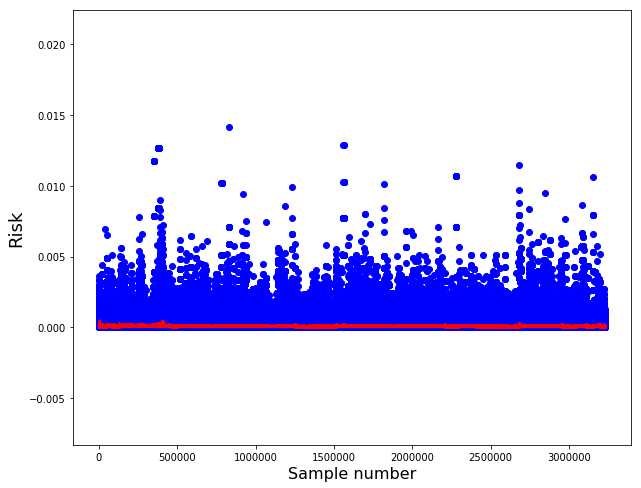

In [20]:
plot_output(y_test.values, y_pred, 'testing')

In [ ]:
y_test.value_counts()

## TPOT

In [ ]:
from tpot import TPOTRegressor

In [ ]:
# %%time

# tpot = TPOTRegressor(generations=10, population_size=10, verbosity=2)
# tpot.fit(X_train, y_train)
# print(tpot.score(X_test, y_test))

In [ ]:
y_val_predict = tpot.predict(X_val)
mean_squared_error(y_val, y_val_predict)

## Update database with model predictions

In [ ]:
# # MODEL PREDICTION HERE

# # Put predictions into pandas DataFrame with corresponding block id
# predictions = pd.DataFrame([[x] for x in list(block_ids)], columns=["id"])

# block_ids = {}
# for i in range(X.shape[0]):
#     block_ids[X.loc[i, 'blockid']] = i

# predictions.loc[:, "prediction"] = predictions["id"].apply(lambda x: y_pred[block_ids[x],:].tobytes().hex())
# predictions.loc[:, "month"] = PREDICTION_START_MONTH
# predictions.loc[:, "year"] = PREDICTION_START_YEAR

# predictions.to_csv("predictions.csv", index=False)

# query_commit_predictions = '''
# CREATE TEMPORARY TABLE temp_predictions (
#     id SERIAL PRIMARY KEY,
#     prediction TEXT,
#     month INTEGER,
#     year INTEGER
# );

# COPY temp_predictions (id, prediction) FROM STDIN DELIMITER ',' CSV HEADER;

# UPDATE block
# SET 
#     prediction = temp_predictions.prediction::BYTEA,
#     month = temp_predictions.month,
#     year = temp_predictions.year 
# FROM temp_predictions
# WHERE block.id = temp_predictions.id;

# DROP TABLE temp_predictions;
# '''

# # Open saved predictions and send to database using above query
# with open("predictions.csv", "r") as f:
#     RAW_CONN = create_engine(DB_URI).raw_connection()
#     cursor = RAW_CONN.cursor()
#     cursor.copy_expert(query_commit_predictions, f)
#     RAW_CONN.commit()
#     RAW_CONN.close()
    
# for r in SESSION.execute("SELECT prediction FROM block LIMIT 5;").fetchall():
#     print(r[0])